In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy.spatial import cKDTree
from nalger_helper_functions import *

In [20]:
# n = 25
# mesh = dl.UnitSquareMesh(n,n)

mesh_center = np.array([0.5, 0.5])
mesh_radius = 0.5
mesh_h = 5e-2 # 1e-2
mesh = circle_mesh(mesh_center, mesh_radius, mesh_h)

V = dl.FunctionSpace(mesh, 'CG', 1)
dof_coords = V.tabulate_dof_coordinates()

u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

xhat = dl.Expression(("1.0", "0.0"), domain=mesh, degree=5)
Dx_true = csr_fenics2scipy(dl.assemble(v_test * dl.inner(xhat, dl.grad(u_trial)) * dl.dx))
Dx_true = Dx_true + 0.0 * (1j * Dx_true)

M = csr_fenics2scipy(dl.assemble(u_trial * v_test * dl.dx))
M = M + 0.0 * (1j * M)
solve_M = spla.factorized(M)

Dx_true_coo = Dx_true.tocoo()

# Dx_true_dense = Dx_true.toarray()

q_true = Dx_true_coo.data.real
rows_true = Dx_true_coo.row
cols_true = Dx_true_coo.col

nq_true = len(q_true)
print('nq_true=', nq_true)

print('V.dim()=', V.dim())

print(nq_true / (V.dim()**2))

nq_true= 5478
V.dim()= 824
0.008068031859741729


/home/nick/anaconda3/envs/fenics3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


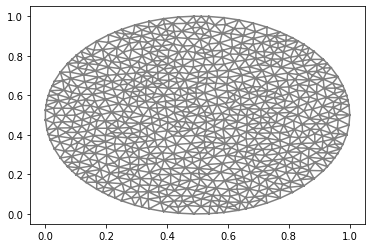

In [21]:
dl.plot(mesh)

In [4]:
# Dx = least_squares_directional_derivative_matrix(dof_coords, np.array([1,0]),
#                                                 a_reg=0.0, num_neighbors=10,
#                                                 num_angles=5, num_frequencies=4,
#                                                 min_points_per_wavelength=30,
#                                                 plot_probing_functions=True,
#                                                 apply_D_true=lambda x: solve_M(Dx_true * x),
#                                                 run_finite_difference_checks=True)

In [22]:
# rows = rows_true
# cols = cols_true

num_neighbors = 10

T = cKDTree(dof_coords)
dd, neighbor_inds = T.query(dof_coords, num_neighbors)

# rows = np.outer(np.arange(V.dim(), dtype=int), np.ones(num_neighbors, dtype=int)).reshape(-1)
# cols = neighbor_inds.reshape(-1)

rows = rows_true
cols = cols_true

nq = len(rows)

min_h = np.min(dd[:,1])
print('min_h=', min_h)

mesh_diameter = np.linalg.norm(np.max(dof_coords, axis=0) - np.min(dof_coords, axis=0))

min_h= 0.024922942830348415


nq= 5478 np.size(X)= 9888


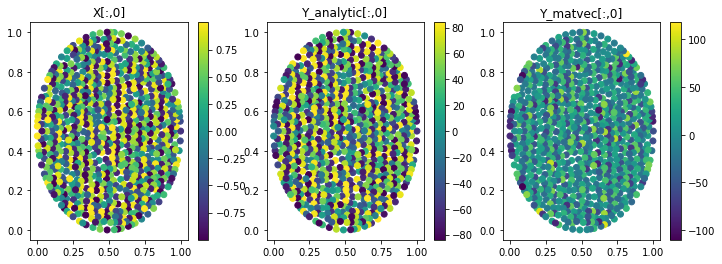

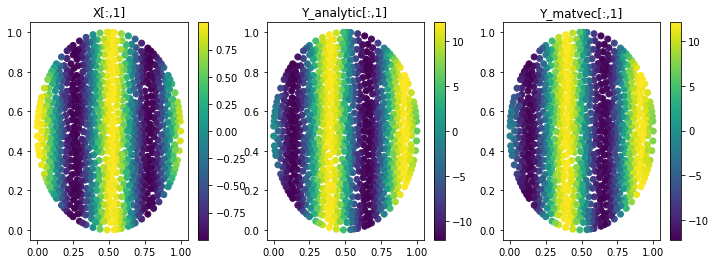

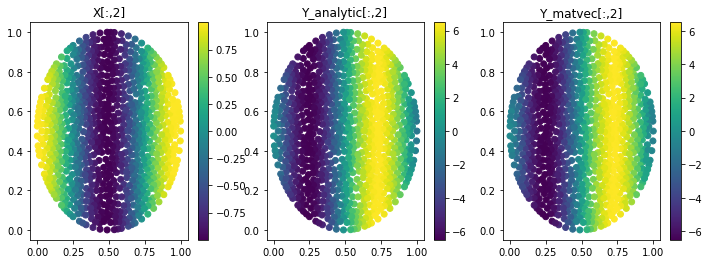

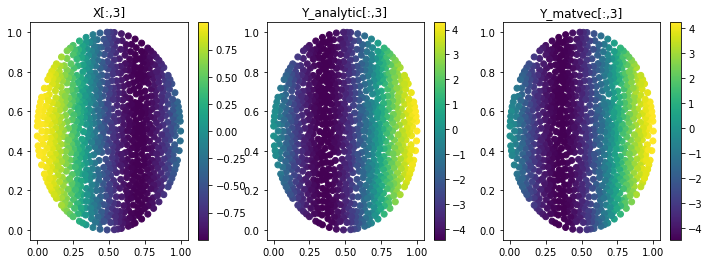

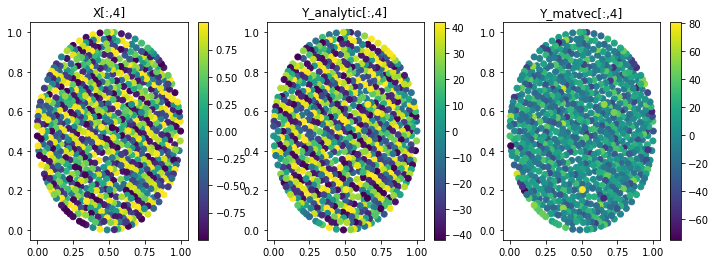

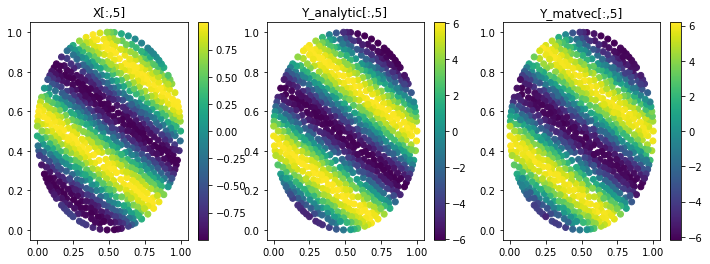

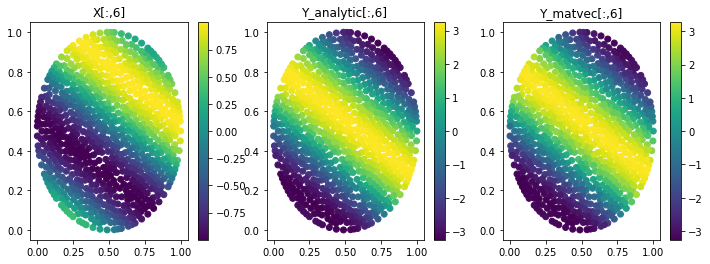

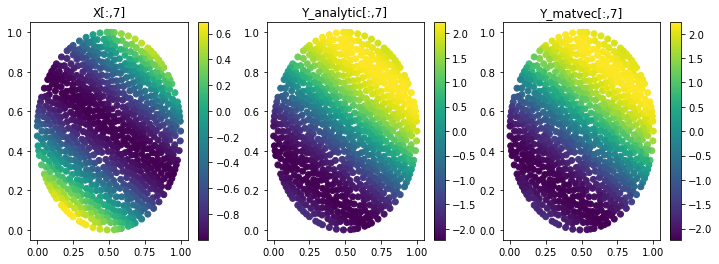

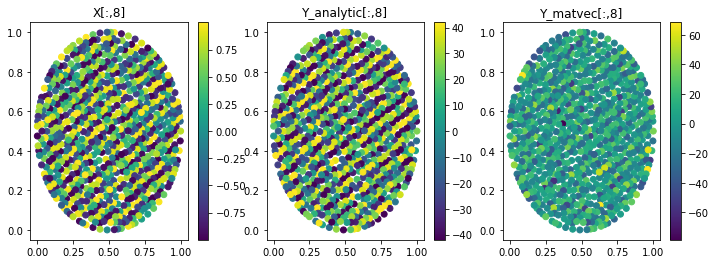

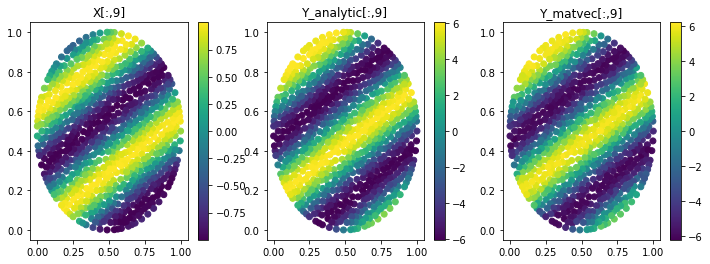

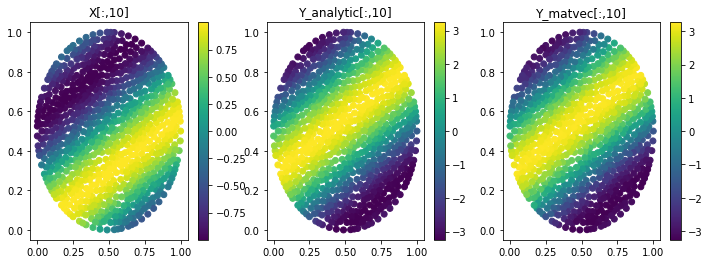

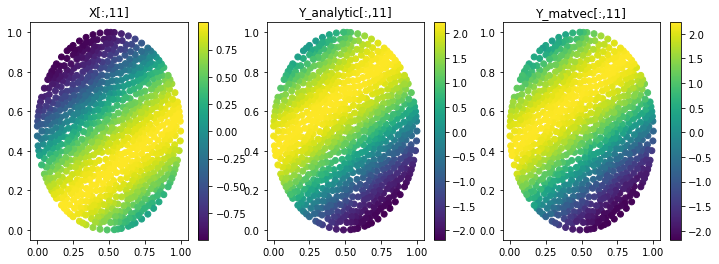

In [41]:
def complex_exponential(theta, omega):
    s = 2. * np.pi * omega * 1j
    vhat = np.array([np.cos(theta), -np.sin(theta)])
    return np.exp(s * np.dot(dof_coords, vhat))

def Dx_complex_exponential(theta, omega):
    s = 2. * np.pi * omega * 1j
    vhat = np.array([np.cos(theta), -np.sin(theta)])
    return s * vhat[0] * np.exp(s * np.dot(dof_coords, vhat))
    

num_thetas = 3 # 15 # 3
num_omegas = 4

thetas = 2. * np.pi * np.arange(num_thetas) / num_thetas

min_L = 30. * min_h
max_L = mesh_diameter
# omegas = 1. / np.logspace(np.log10(min_L), np.log10(max_L), num_omegas)
omegas = 1. / np.linspace(min_L, max_L, num_omegas)
# omegas = np.array([1,2])
# omegas = np.array([1., 1./2., 1./3.]) / (mesh_h * 10.)

num_omegas = len(omegas)

X = np.zeros((V.dim(), num_thetas, num_omegas), dtype=complex)
Y_analytic = np.zeros((V.dim(), num_thetas, num_omegas), dtype=complex)
for ii in range(num_thetas):
    for jj in range(num_omegas):
        X[:,ii,jj] = complex_exponential(thetas[ii], omegas[jj])
        Y_analytic[:,ii,jj] = Dx_complex_exponential(thetas[ii], omegas[jj])

X = X.reshape((V.dim(), -1))
Y_analytic = Y_analytic.reshape((V.dim(), -1))

Y_matvec = solve_M(Dx_true * X)

for k in range(X.shape[1]):
    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.scatter(dof_coords[:,0], dof_coords[:,1], c=X[:,k].real)
    plt.colorbar()
    plt.title('X[:,' + str(k) + ']')

    plt.subplot(132)
    plt.scatter(dof_coords[:,0], dof_coords[:,1], c=Y_analytic[:,k].real)
    plt.colorbar()
    plt.title('Y_analytic[:,' + str(k) + ']')

    plt.subplot(133)
    plt.scatter(dof_coords[:,0], dof_coords[:,1], c=Y_matvec[:,k].real)
    plt.colorbar()
    plt.title('Y_matvec[:,' + str(k) + ']')

print('nq=', nq, 'np.size(X)=', np.size(X))

In [42]:
def make_Dx_matrix(q):
    return sps.coo_matrix((q, (rows, cols)), shape=(V.dim(), V.dim()), dtype=complex).tocsr()


def Dx_dq_mode3_contraction(z):
    return sps.coo_matrix((z[cols], (rows, np.arange(nq))), shape=(V.dim(), nq), dtype=complex).tocsr()


z = np.random.randn(V.dim())

q1 = np.random.randn(nq)
Dx1 = make_Dx_matrix(q1)

s = 1e-7
dq = np.random.randn(nq)
q2 = q1 + s * dq

delta = Dx_dq_mode3_contraction(z) * dq

Dx2 = make_Dx_matrix(q2)

delta_diff = (Dx2 * z - Dx1 * z) / s

err_Dx_dq_mode3_contraction = np.linalg.norm(delta - delta_diff) / np.linalg.norm(delta_diff)
print('s=', s, ', err_Dx_dq_mode3_contraction=', err_Dx_dq_mode3_contraction)

s= 1e-07 , err_Dx_dq_mode3_contraction= 1.705266194592119e-09


<ipython-input-43-8b0bc3d7c87d>:63: RuntimeWarning: divide by zero encountered in double_scalars
  err_grad = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)


s= 1e-15 , err_grad= inf , err_hess= 0.43413472572736556
s= 1e-14 , err_grad= inf , err_hess= 0.05806469366371847
s= 1e-13 , err_grad= inf , err_hess= 0.006115909479177089
s= 1e-12 , err_grad= 0.337607319936423 , err_hess= 0.0006257478602284407
s= 1e-11 , err_grad= 0.10398780010596165 , err_hess= 6.301846704373834e-05
s= 1e-10 , err_grad= 0.006166096299104282 , err_hess= 6.228238061182471e-06
s= 1e-09 , err_grad= 0.0005931723014759322 , err_hess= 6.286104100003969e-07
s= 1e-08 , err_grad= 1.4110756979069034e-05 , err_hess= 6.533294907452615e-08
s= 1e-07 , err_grad= 9.862263453954692e-07 , err_hess= 6.611855154096058e-09
s= 1e-06 , err_grad= 9.078378555806795e-06 , err_hess= 6.442800733919613e-10
s= 1e-05 , err_grad= 9.060914541997587e-05 , err_hess= 6.607824950315058e-11
s= 0.0001 , err_grad= 0.0009068074071412549 , err_hess= 6.672558862187641e-12
s= 0.001 , err_grad= 0.009142671186410435 , err_hess= 6.506213779818898e-13
s= 0.01 , err_grad= 0.09962418746727436 , err_hess= 6.6183691852

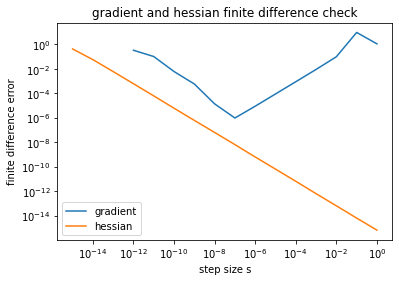

In [43]:
a_reg = 1e-6

Y = Y_analytic


def objective(q):
    Dx = make_Dx_matrix(q)
    Res = Y - Dx * X
    Jd = 0.5 * np.linalg.norm(Res)**2
    Jr = 0.5 * a_reg * np.linalg.norm(q)**2
    return Jd + Jr


def gradient(q):
    Dx = make_Dx_matrix(q)
    Res = Y - Dx * X
    
    gd = np.zeros(len(q))
    for k in range(len(q)):
        gd[k] = -np.dot(Res[rows[k],:].conj(), X[cols[k],:]).real
    
    gr = a_reg * q
    
    return gd + gr


def hessian():
    HH = list()
    for k in range(X.shape[1]):
        Jk = Dx_dq_mode3_contraction(X[:,k])
        Hk = Jk.H * Jk
        HH.append(Hk.real)
    
    Hd = HH[0]
    for Hdk in HH[1:]:
        Hd += Hdk
        
    Hr = a_reg * sps.eye(Hd.shape[0]).tocsr()
    
    return Hd + Hr


q1 = np.random.randn(nq)
J1 = objective(q1)
g1 = gradient(q1)
H1 = hessian()

dq = np.random.randn(nq)
dJ = np.dot(g1, dq)

dg = H1 * dq

ss = np.logspace(-15, 0, 16)
errs_grad = np.zeros(len(ss))
errs_hess = np.zeros(len(ss))

for k in range(len(ss)):
    s = ss[k]
    q2 = q1 + s * dq
    
    J2 = objective(q2)
    dJ_diff = (J2 - J1) / s
    err_grad = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
    errs_grad[k] = err_grad
    
    g2 = gradient(q2)
    dg_diff = (g2 - g1) / s
    err_hess = np.linalg.norm(dg - dg_diff) / np.linalg.norm(dg_diff)
    errs_hess[k] = err_hess
    
    print('s=', s, ', err_grad=', err_grad, ', err_hess=', err_hess)
    
plt.figure()
plt.loglog(ss, errs_grad)
plt.loglog(ss, errs_hess)
plt.legend(['gradient', 'hessian'])
plt.xlabel('step size s')
plt.ylabel('finite difference error')
plt.title('gradient and hessian finite difference check')

hessian_fraction_nonzero = H1.nnz / np.prod(H1.shape)
print('hessian_fraction_nonzero=', hessian_fraction_nonzero)

In [44]:
g0 = gradient(np.zeros(nq))
q = spla.spsolve(H1, -g0)

err_df_dx_fem_vs_lsq= 1.501186337676766
err_df_dx_fem_vs_analytic= 0.07492224039802196
err_df_dx_lsq_vs_analytic= 1.501793192591211


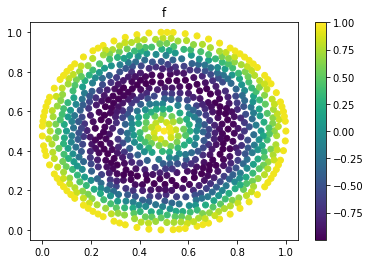

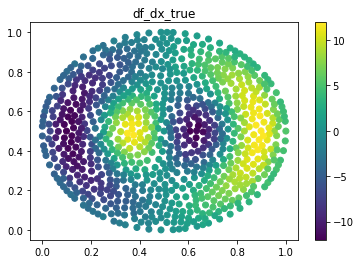

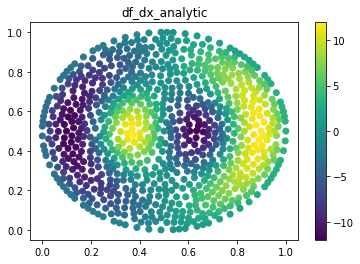

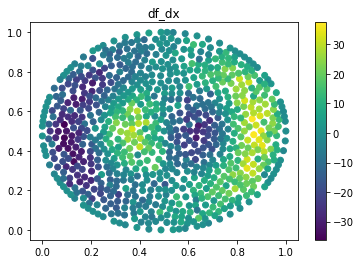

In [45]:
Dx = make_Dx_matrix(q)

f = np.cos(12 * np.linalg.norm(dof_coords - 0.5, axis=1))

num = -12 * (dof_coords[:,0]-0.5) * np.sin(12 * np.linalg.norm(dof_coords - 0.5, axis=1))
denom = np.linalg.norm(dof_coords - 0.5, axis=1)

df_dx_analytic =  num / denom

df_dx_fem = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx_fem_vs_lsq = np.linalg.norm(df_dx_fem - df_dx) / np.linalg.norm(df_dx_fem)
print('err_df_dx_fem_vs_lsq=', err_df_dx_fem_vs_lsq)

err_df_dx_fem_vs_analytic = np.linalg.norm(df_dx_fem - df_dx_analytic) / np.linalg.norm(df_dx_analytic)
print('err_df_dx_fem_vs_analytic=', err_df_dx_fem_vs_analytic)

err_df_dxlsq_vs_analytic = np.linalg.norm(df_dx - df_dx_analytic) / np.linalg.norm(df_dx_analytic)
print('err_df_dx_lsq_vs_analytic=', err_df_dxlsq_vs_analytic)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_analytic)
plt.title('df_dx_analytic')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

err_df_dx= 0.1007037708606175


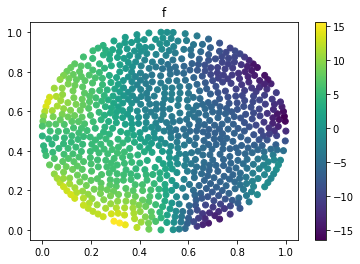

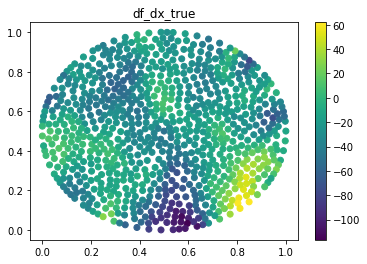

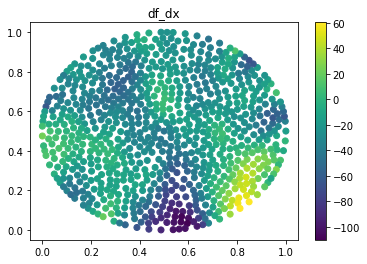

In [28]:
A = csr_fenics2scipy(dl.assemble(dl.inner(dl.grad(u_trial), dl.grad(v_test))*dl.dx + 100.*u_trial*v_test*dl.dx))

f = spla.spsolve(A * A, np.random.randn(V.dim()))

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

err_df_dx= 0.4835516401655017


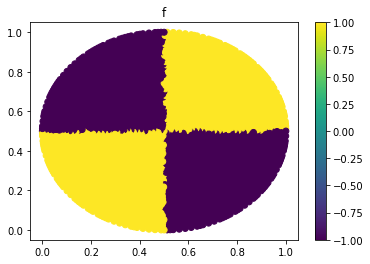

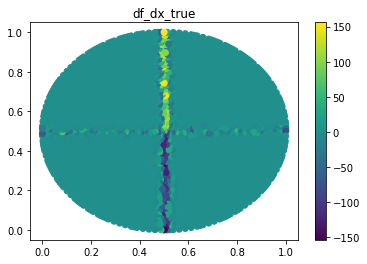

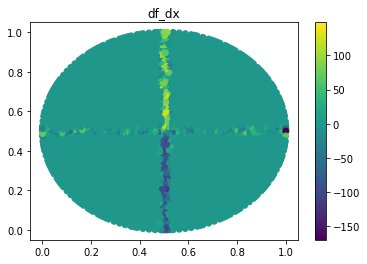

In [12]:
f1 = 2. * (dof_coords[:,0] > 0.5) - 1
f2 = 2. * (dof_coords[:,1] > 0.5) - 1
f = f1 * f2

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

cg_iters =  10 err_cg= 0.9355041403295763
cg_iters =  20 err_cg= 0.9217083973014992
cg_iters =  30 err_cg= 0.9107704621664529
cg_iters =  40 err_cg= 0.9021435751882334
cg_iters =  50 err_cg= 0.8943971437691254
cg_iters =  60 err_cg= 0.8903554484682843
cg_iters =  70 err_cg= 0.8857358140920939
cg_iters =  80 err_cg= 0.8807349673280641
cg_iters =  90 err_cg= 0.8779662327051185
cg_iters =  100 err_cg= 0.876312553266825


Text(0.5, 1.0, 'CG convergence (unpreconditioned), a_reg=1e-06')

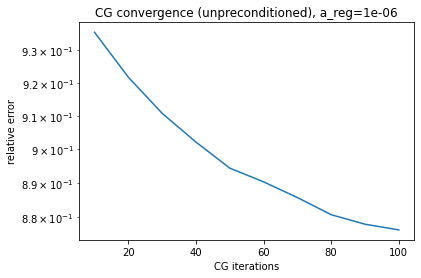

In [13]:
all_cg_iters = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

errs_cg = np.zeros(len(all_cg_iters))
for k in range(len(all_cg_iters)):
    cg_iters = all_cg_iters[k]
    
    q_cg, _ = spla.cg(H1, -g0, tol=1e-15, maxiter=cg_iters)
    
    err_cg = np.linalg.norm(q_cg - q) / np.linalg.norm(q)
    errs_cg[k] = err_cg
    print('cg_iters = ', cg_iters, 'err_cg=', err_cg)
    
plt.figure()
plt.semilogy(all_cg_iters, errs_cg)
plt.xlabel('CG iterations')
plt.ylabel('relative error')
plt.title('CG convergence (unpreconditioned), a_reg=' + str(a_reg))

In [14]:
H1.shape

(32670, 32670)

[0 1 2 3 4 5 6 7 8 9]


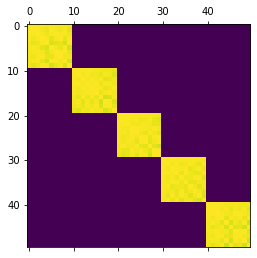

In [15]:


k = 12600

H20 = H1[:50,:][:,:50].toarray()

print(H1[3,:].tocoo().col)

# print('H20=', H20)

plt.matshow(H20)

# print('k_rows=', k_rows)
# print('neighbor_inds[k,:]=', neighbor_inds[k,:])

# H1_kk = H1[k_rows, :][:, k_rows].toarray()

# _,ss,_ = np.linalg.svd(H1_kk)

# print('ss=', ss)

# np.argwhere(k_rows == k).reshape(-1)